In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import time
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.datasets import mnist, fashion_mnist

# Load Data


In [2]:
# Function to normalize a dataset
def normalize_data(matrix):
    scaler = MinMaxScaler()
    return scaler.fit_transform(matrix)

# Load MNIST dataset
def load_mnist():
    print("Loading MNIST dataset...")
    (X_train, _), (_, _) = mnist.load_data()
    X_train = X_train.reshape(X_train.shape[0], -1)  # Flatten images
    print(f"MNIST dataset loaded with shape: {X_train.shape}")
    return normalize_data(X_train)

# Load Fashion-MNIST dataset
def load_fashion_mnist():
    print("Loading Fashion-MNIST dataset...")
    (X_train, _), (_, _) = fashion_mnist.load_data()
    X_train = X_train.reshape(X_train.shape[0], -1)  # Flatten images
    print(f"Fashion-MNIST dataset loaded with shape: {X_train.shape}")
    return normalize_data(X_train)

# Load Covertype dataset
def load_covertype():
    print("Loading Covertype dataset...")
    url = "https://archive.ics.uci.edu/ml/machine-learning-databases/covtype/covtype.data.gz"
    columns = [f"Feature_{i+1}" for i in range(54)] + ["Cover_Type"]
    covertype_df = pd.read_csv(url, header=None, names=columns)
    X = covertype_df.iloc[:, :-1].to_numpy()
    print(f"Covertype dataset loaded with shape: {X.shape}")
    return normalize_data(X)

# Load and preprocess the MovieLens dataset
def load_movielens():
    print("Loading MovieLens dataset...")

    # URL to the MovieLens dataset (replace with the appropriate dataset URL)
    url = 'https://files.grouplens.org/datasets/movielens/ml-latest.zip'

    # Download and extract the ZIP file (You can use `zipfile` to extract it)
    import zipfile
    import io
    import requests

    # Download the ZIP file
    response = requests.get(url)

    # Extract the ZIP file content
    with zipfile.ZipFile(io.BytesIO(response.content)) as z:
        # Read the ratings.csv file
        with z.open('ml-latest/ratings.csv') as f:
            ratings_df = pd.read_csv(f)

    # Group by userId and movieId to create a user-item matrix
    user_movie_matrix = ratings_df.pivot(index='userId', columns='movieId', values='rating')

    # Replace NaN values with the mean rating of the respective user
    user_movie_matrix_filled = user_movie_matrix.apply(lambda row: row.fillna(row.mean()), axis=1)

    # Convert the matrix to a NumPy array
    matrix = user_movie_matrix_filled.to_numpy()

    # Optionally normalize the data
    normalized_matrix = normalize_data(matrix)

    print("MovieLens dataset loaded and preprocessed.")
    print(f"Shape of the preprocessed matrix: {normalized_matrix.shape}")

    return normalized_matrix

In [3]:
# Load datasets
datasets = {}
datasets['MNIST'] = load_mnist()
datasets['Fashion-MNIST'] = load_fashion_mnist()
datasets['Covertype'] = load_covertype()
# datasets['MovieLens'] = load_movielens()

# Print summaries of all datasets
print("\nSummary of loaded datasets:")
for name, data in datasets.items():
    print(f"{name}: Shape = {data.shape}")

Loading MNIST dataset...
MNIST dataset loaded with shape: (60000, 784)
Loading Fashion-MNIST dataset...
Fashion-MNIST dataset loaded with shape: (60000, 784)
Loading Covertype dataset...
Covertype dataset loaded with shape: (581012, 54)

Summary of loaded datasets:
MNIST: Shape = (60000, 784)
Fashion-MNIST: Shape = (60000, 784)
Covertype: Shape = (581012, 54)


In [4]:
for name, data in datasets.items():
    print(f"Summary Statistics for {name}:")
    print(f" - Shape: {data.shape}")
    print(f" - Mean: {np.mean(data):.4f}")
    print(f" - Std Dev: {np.std(data):.4f}")
    print(f" - Min: {np.min(data):.4f}")
    print(f" - Max: {np.max(data):.4f}")
    print(f" - Number of NaNs: {np.isnan(data).sum()}")

Summary Statistics for MNIST:
 - Shape: (60000, 784)
 - Mean: 0.1307
 - Std Dev: 0.3081
 - Min: 0.0000
 - Max: 1.0000
 - Number of NaNs: 0
Summary Statistics for Fashion-MNIST:
 - Shape: (60000, 784)
 - Mean: 0.2861
 - Std Dev: 0.3530
 - Min: 0.0000
 - Max: 1.0000
 - Number of NaNs: 0
Summary Statistics for Covertype:
 - Shape: (581012, 54)
 - Mean: 0.1214
 - Std Dev: 0.2758
 - Min: 0.0000
 - Max: 1.0000
 - Number of NaNs: 0


# Algorithms

## Empirical Mean

In [5]:
def emp_mean_accuracy(train_ds, sample_size, reps=50):
  errors = []
  x_min = np.mean(train_ds, axis=0)
  OPT = np.sum(np.linalg.norm(train_ds - x_min, axis=1)**2)
  n, d = train_ds.shape
  for _ in range(reps):
    sample_indices = np.random.choice(n, sample_size, replace=False)
    sample = train_ds[sample_indices, :]
    emp_mean = np.mean(sample, axis=0)
    obj_value = np.sum(np.linalg.norm(train_ds - emp_mean, axis=1)**2)
    error = obj_value/OPT
    errors.append(error)
  return errors

## Common subroutines: Compute empirical means and winner

In [6]:
def compute_empirical_means(train_ds, sample_size):
    """
    Compute empirical means of random subsets of the dataset and count good means.

    Parameters:
    - train_ds: The training dataset (numpy array).
    - epsilon: The error tolerance.
    - delta: The failure probability.

    Returns:
    - empirical_means: A numpy array of empirical means computed from subsets.
    """
    n, d = train_ds.shape

    num_batches = min(n, max(3, int(np.log(sample_size))))
    batch_size = sample_size//num_batches

    empirical_means = np.zeros((num_batches, d))

    for i in range(num_batches):
        # Sample a subset of the dataset
        sample_indices = np.random.choice(n, batch_size, replace=False)
        sample = train_ds[sample_indices, :]

        # Compute the empirical mean for the subset
        emp_mean = np.mean(sample, axis=0)
        empirical_means[i, :] = emp_mean

    # Compute a random initial guess
    sample_indices = np.random.choice(n, batch_size, replace=False)
    sample = train_ds[sample_indices, :]
    emp_mean = np.mean(sample, axis=0)
    rand_initial_guess = emp_mean

    return empirical_means, rand_initial_guess

In [7]:
def compute_winner(P):
    """
    Computes the winner point in the set P based on the algorithm.

    Parameters:
    - P: numpy array of shape (n, d), where n is the number of points and d is the dimension.

    Returns:
    - winner_index: int, the index of the point in P that minimizes D_j.
    """
    m, d = P.shape
    distances = np.zeros(m)  # Array to store D_j values for each point

    for j, p_j in enumerate(P):
        # Compute distances from p_j to all other points
        all_distances = np.linalg.norm(P - p_j, axis=1)

        # Find the threshold distance for the 7/10 closest point
        k = int(0.7 * m)
        threshold_distance = np.partition(all_distances, k)[k]

        # Compute D_j as the sum of distances for points within the threshold
        distances[j] = np.sum(all_distances[all_distances <= threshold_distance])

    # Find the point that minimizes D_j
    winner_index = np.argmin(distances)
    winner_point = P[winner_index]
    return winner_point

## Fast Gradient Descent

In [8]:
def fast_gd(P, initial_guess):
    """
    Fast Gradient Descent (FastGD) for geometric median computation.

    Parameters:
    - P: numpy array of shape (n, d), where n is the number of points, and d is the dimension.
    - sample_size: int, number of samples given to the algorithm.
    - initial_guess: numpy array of shape (d,), initial guess for the geometric median.

    Returns:
    - c_T: numpy array of shape (d,), the computed geometric median after T iterations.
    """
    m, d = P.shape

    # Initialize the geometric median with the mean of the points or the provided initial guess
    c_prev = initial_guess

    num_batches = max(3, int(np.log(m)))
    T = 50 * num_batches

    for _ in range(T):
        for p in P:
          if np.isnan(np.linalg.norm(p - c_prev)):
            break
        # Compute the gradient ∇(c_prev)
        gradient = np.sum([(p - c_prev) / np.linalg.norm(p - c_prev) for p in P], axis=0)

        # Direction: ∇(c_prev) - c_prev
        direction = gradient - c_prev
        direction_norm = np.linalg.norm(direction)
        if direction_norm == 0:
            break  # Stop if direction becomes 0 to avoid division by zero
        direction /= direction_norm

        # Project all points onto the line defined by direction
        projections = np.dot(P - c_prev, direction)

        # Compute the 1-dimensional median of the projections
        median_projection = np.median(projections)

        # Update c_prev: Move along the line to the median projection
        c_next = c_prev + median_projection * direction

        # Update the current guess
        c_prev = c_next

    return c_prev

def fastgd_accs_runtimes(sample_size, train_ds, OPT, init, reps=50):
    n, d = train_ds.shape
    accuracies = []
    runtimes = []
    for _ in range(reps):
      start_time = time.time()
      P, rand_initial_guess = compute_empirical_means(train_ds, sample_size)
      if init == 'rand':
        initial_guess = rand_initial_guess # randomly seeded initial guess
      else:
        initial_guess = np.median(P, axis=0) # seeded initial guess is coordinate-wise median
      c = fast_gd(P, initial_guess)
      loss = np.sum(np.linalg.norm(train_ds - c, axis=1)**2)
      if np.isnan(loss):
          break
      runtimes.append(time.time() - start_time)
      accuracies.append(loss/OPT)
    return accuracies, runtimes

## MinSumSelect

In [9]:
def minsumselect(P, i=1):
    """
    Implements the MinSumSelect algorithm with recursion depth i, default i=1.

    Parameters:
    - P: numpy array of shape (n, d), the set of points.
    - i: int, recursion depth.

    Returns:
    - winner_point: numpy array of shape (d,), the point that minimizes the sum of distances.
    """
    if i == 0 or len(P) == 1:
        return compute_winner(P)

    # Number of clusters: sqrt(|P|)
    m = len(P)
    cluster_size = int(np.sqrt(m))
    clusters = [P[k:k + cluster_size] for k in range(0, m, cluster_size)]

    # Initialize the winner set W
    W = []

    # Process each cluster recursively
    for cluster in clusters:
        winner = minsumselect(cluster, i - 1)
        W.append(winner)

    # Compute the winner of W
    W = np.array(W)
    return compute_winner(W)

def minsum_accs_runtimes(sample_size, train_ds, OPT, reps=50):
    n, d = train_ds.shape
    accuracies = []
    runtimes = []
    for _ in range(reps):
      start_time = time.time()
      P, _ = compute_empirical_means(train_ds, sample_size)
      c = minsumselect(P)
      loss = np.sum(np.linalg.norm(train_ds - c, axis=1)**2)
      if np.isnan(loss):
          break
      runtimes.append(time.time() - start_time)
      accuracies.append(loss/OPT)
    return accuracies, runtimes

## Ring Sampling (Cohen-Addad, Saulpic, Schwiegelshohn, NeurIPS 2022)

In [10]:
def css(P, sample_size):
    n, d = P.shape
    points = P

    num_batches = min(n, max(3, int(np.log(sample_size))))
    batch_size = sample_size//num_batches

    # Compute initial solution
    sample_indices = np.random.choice(n, num_batches, replace=False)
    sample = P[sample_indices, :]
    winner = compute_winner(sample)

    # Discard far points
    all_distances = np.linalg.norm(P - winner, axis=1)
    k = int(0.95 * n)
    threshold_distance = np.partition(all_distances, k)[k]
    indices = P[all_distances <= threshold_distance]

    return np.mean(indices, axis=0)

def css_accs_runtimes(sample_size, train_ds, OPT, reps=50):
    n, d = train_ds.shape
    accuracies = []
    runtimes = []
    for _ in range(reps):
      start_time = time.time()
      # P, _ = compute_empirical_means(train_ds, sample_size)
      c = css(train_ds, sample_size)
      loss = np.sum(np.linalg.norm(train_ds - c, axis=1)**2)
      if np.isnan(loss):
          break
      runtimes.append(time.time() - start_time)
      accuracies.append(loss/OPT)
    return accuracies, runtimes

## Coresets for Multiple $\ell_p$ Regression (Woodruff and Yasuda, ICML 2024)

In [11]:
def wy(P, sample_size):
    n, d = P.shape
    points = P

    num_batches = min(n, max(3, int(np.log(sample_size))))
    batch_size = sample_size//num_batches

    # Compute initial solution
    sample_indices = np.random.choice(n, num_batches, replace=False)
    sample = P[sample_indices, :]
    winner = compute_winner(sample)

    # Subtract winner from each point
    for j, p_j in enumerate(P):
      points[j] = P[j] - winner

    empirical_means = np.zeros((num_batches, d))
    distances = np.zeros(num_batches)

    result = 0

    for i in range(num_batches):
        # Sample a subset of the dataset
        sample_indices = np.random.choice(n, batch_size, replace=False)
        sample = train_ds[sample_indices, :]

        # Compute the empirical mean for the subset
        emp_mean = np.mean(sample, axis=0)
        empirical_means[i, :] = emp_mean

        # Compute cost for each empirical mean
        distances[i] = np.sum(np.square(np.linalg.norm(sample - emp_mean, axis=1)))

        # Maintain minimum cost
        if (distances[i] < distances[result]):
            result = i

    return empirical_means[result]

def wy_accs_runtimes(sample_size, train_ds, OPT, reps=50):
    n, d = train_ds.shape
    accuracies = []
    runtimes = []
    for _ in range(reps):
      start_time = time.time()
      # P, _ = compute_empirical_means(train_ds, sample_size)
      c = wy(train_ds, sample_size)
      loss = np.sum(np.linalg.norm(train_ds - c, axis=1)**2)
      if np.isnan(loss):
          break
      runtimes.append(time.time() - start_time)
      accuracies.append(loss/OPT)
    return accuracies, runtimes

# Run simulations on all algorithms

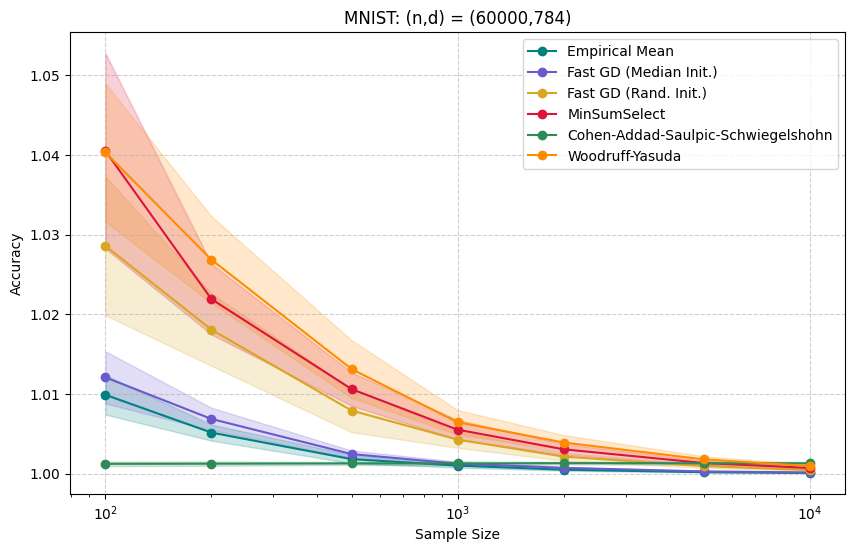

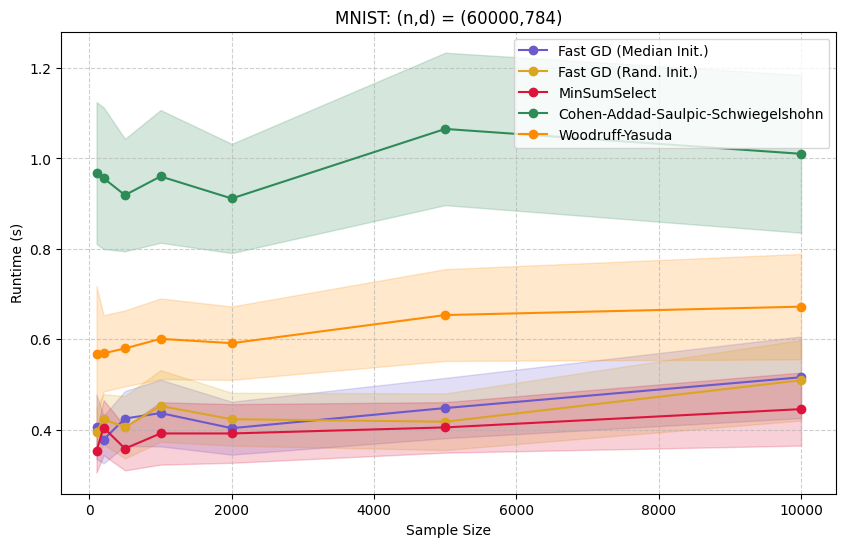

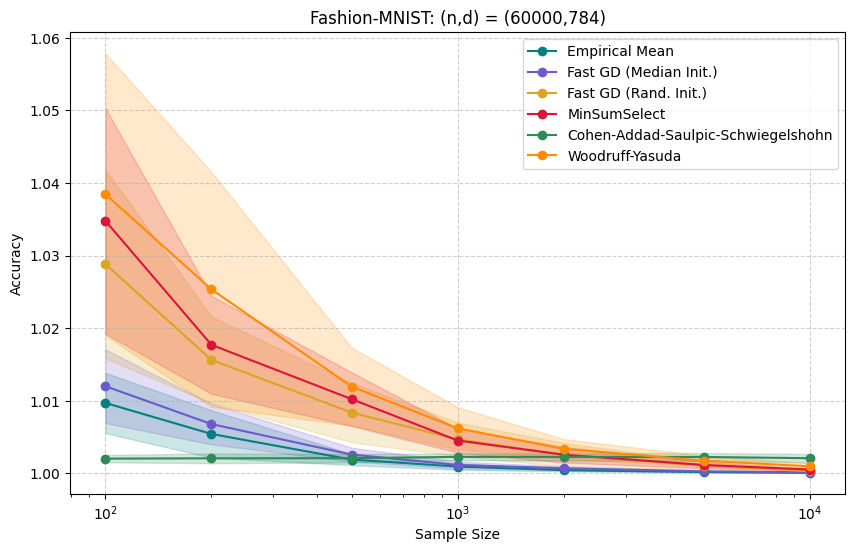

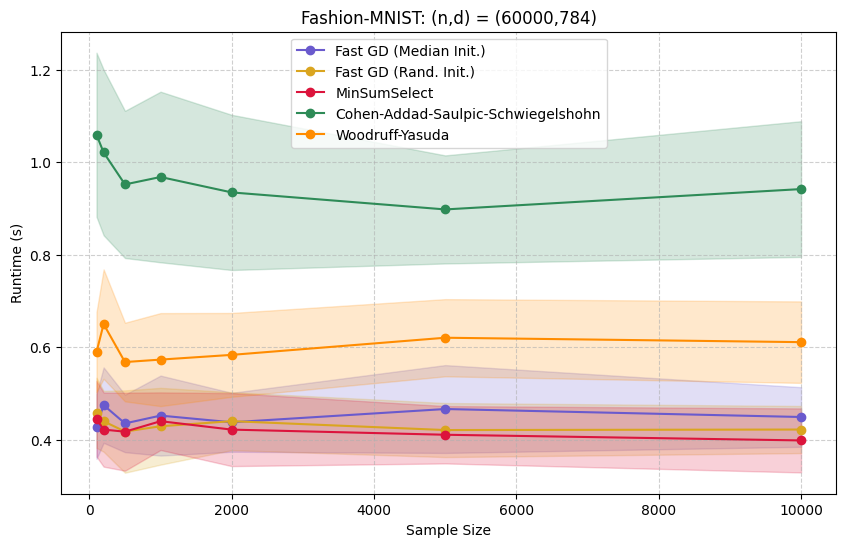

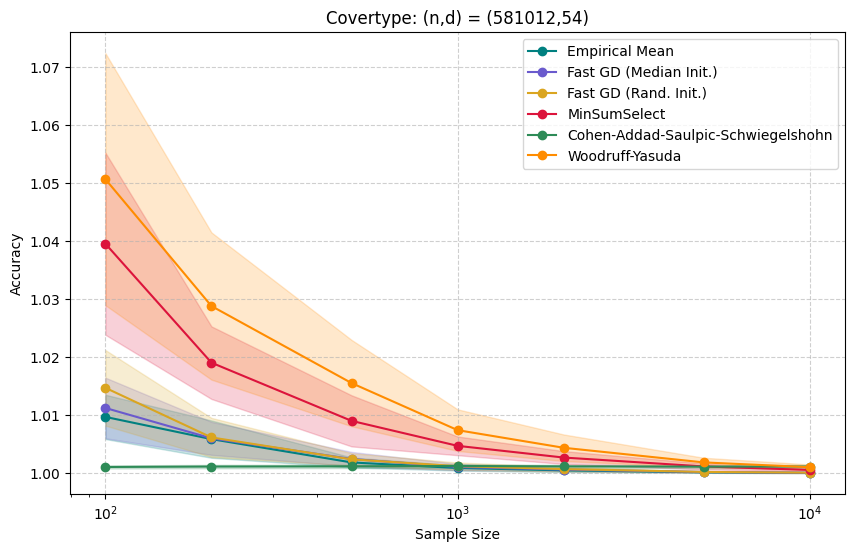

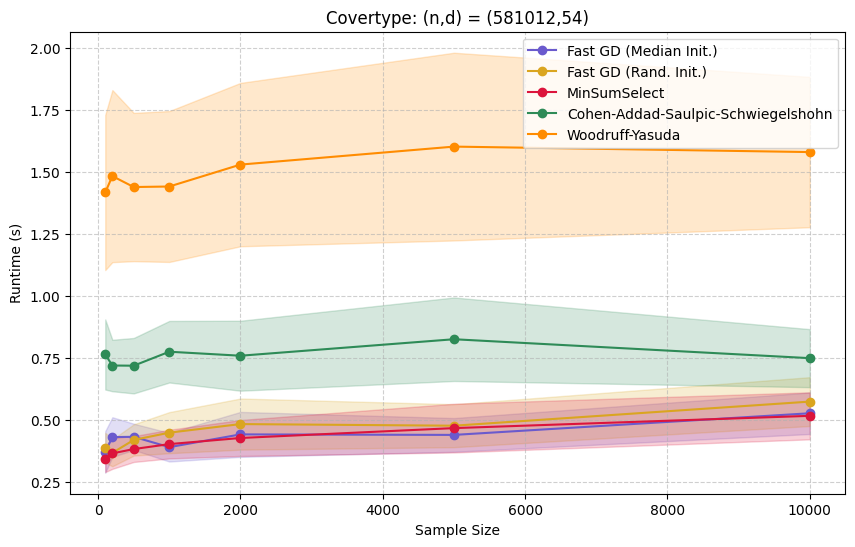

In [12]:
for dataset_name, train_ds in datasets.items():
  # if dataset_name == 'MovieLens':
    n, d = train_ds.shape
    sample_sizes = [100, 200, 500, 1000, 2000, 5000, 10000]

    x_min = np.mean(train_ds, axis=0)
    OPT = np.sum(np.linalg.norm(train_ds - x_min, axis=1)**2)

    empmean_accuracies = []
    fastgd_accuracies = []
    fastgd_runtimes = []
    minsum_accuracies = []
    minsum_runtimes = []
    fastgd_rand_accuracies = []
    fastgd_rand_runtimes = []
    wy_accuracies = []
    wy_runtimes = []
    css_accuracies = []
    css_runtimes = []

    for sample_size in sample_sizes:
      empmean_accuracies_sample = emp_mean_accuracy(train_ds, sample_size)
      empmean_accuracies.append(empmean_accuracies_sample)
      fastgd_accuracies_sample, fastgd_runtimes_sample = fastgd_accs_runtimes(sample_size, train_ds, OPT, init='median')
      fastgd_accuracies.append(fastgd_accuracies_sample)
      fastgd_runtimes.append(fastgd_runtimes_sample)
      fastgd_rand_accuracies_sample, fastgd_rand_runtimes_sample = fastgd_accs_runtimes(sample_size, train_ds, OPT, init='rand')
      fastgd_rand_accuracies.append(fastgd_rand_accuracies_sample)
      fastgd_rand_runtimes.append(fastgd_rand_runtimes_sample)
      minsum_accuracies_sample, minsum_runtimes_sample = minsum_accs_runtimes(sample_size, train_ds, OPT)
      minsum_accuracies.append(minsum_accuracies_sample)
      minsum_runtimes.append(minsum_runtimes_sample)
      wy_accuracies_sample, wy_runtimes_sample = wy_accs_runtimes(sample_size, train_ds, OPT)
      wy_accuracies.append(wy_accuracies_sample)
      wy_runtimes.append(wy_runtimes_sample)
      css_accuracies_sample, css_runtimes_sample = css_accs_runtimes(sample_size, train_ds, OPT)
      css_accuracies.append(css_accuracies_sample)
      css_runtimes.append(css_runtimes_sample)

    # Various algorithms
    experiments_accuracies = [empmean_accuracies, fastgd_accuracies, fastgd_rand_accuracies, minsum_accuracies, css_accuracies, wy_accuracies]
    experiments_runtimes = [fastgd_runtimes, fastgd_rand_runtimes, minsum_runtimes, css_runtimes, wy_runtimes]

    # Colors and labels for each set (in accuracies)
    colors_acc = ['#008080', '#6A5ACD', '#DAA520', '#DC143C', '#2E8B57', '#FF8C00']
    labels_acc = ['Empirical Mean', 'Fast GD (Median Init.)', 'Fast GD (Rand. Init.)', 'MinSumSelect', 'Cohen-Addad-Saulpic-Schwiegelshohn', 'Woodruff-Yasuda']

    # Plot each set of experiments for accuracies
    plt.figure(figsize=(10, 6))

    for idx, experiment_set in enumerate(experiments_accuracies):
        # Compute means and standard deviations for the current set
        avgs = [np.mean(results) for results in experiment_set]
        std_devs = [np.std(results) for results in experiment_set]

        # Plot the mean curve
        plt.plot(sample_sizes, avgs, marker='o', label=labels_acc[idx], color=colors_acc[idx])

        # Add shaded area for standard deviation
        plt.fill_between(
            sample_sizes,
            [m - s for m, s in zip(avgs, std_devs)],  # Lower bound
            [m + s for m, s in zip(avgs, std_devs)],  # Upper bound
            color=colors_acc[idx],
            alpha=0.2
        )

    # Customize the plot
    plt.xscale('log')
    plt.xlabel('Sample Size')
    plt.ylabel('Accuracy')
    plt.title(dataset_name + ": (n,d) = (" + str(n) + "," + str(d) + ")")
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.legend()
    plt.show()

    # Colors and labels for each set (in runtimes)
    colors_run = ['#6A5ACD', '#DAA520', '#DC143C', '#2E8B57', '#FF8C00']
    labels_run = ['Fast GD (Median Init.)', 'Fast GD (Rand. Init.)', 'MinSumSelect', 'Cohen-Addad-Saulpic-Schwiegelshohn', 'Woodruff-Yasuda']

    # Plot each set of experiments for runtimes
    plt.figure(figsize=(10, 6))

    for idx, experiment_set in enumerate(experiments_runtimes):
        # Compute means and standard deviations for the current set
        avgs = [np.mean(results) for results in experiment_set]
        std_devs = [np.std(results) for results in experiment_set]

        # Plot the mean curve
        plt.plot(sample_sizes, avgs, marker='o', label=labels_run[idx], color=colors_run[idx])

        # Add shaded area for standard deviation
        plt.fill_between(
            sample_sizes,
            [m - s for m, s in zip(avgs, std_devs)],  # Lower bound
            [m + s for m, s in zip(avgs, std_devs)],  # Upper bound
            color=colors_run[idx],
            alpha=0.2
        )

    # Customize the plot
    plt.xlabel('Sample Size')
    plt.ylabel('Runtime (s)')
    plt.title(dataset_name + ": (n,d) = (" + str(n) + "," + str(d) + ")")
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.legend()
    plt.show()

# **Woodruff/Yasuda**

In [ ]:
def WY(P):
    n,d = P.shape
    points = P

    num_batches = min(n, max(3, int(np.log(sample_size))))
    batch_size = sample_size//num_batches

    #Compute initial solution
    sample_indices = np.random.choice(n, num_batches, replace=False)
    sample = P[sample_indices, :]
    winner = compute_winner(sample)

    #subtract winner from each point
    for j, p_j in enumerate(P):
      points[j] = P[j]-winner

    empirical_means = np.zeros((num_batches, d))
    distances = np.zeros(num_batches)

    result = 0

    for i in range(num_batches):
        # Sample a subset of the dataset
        sample_indices = np.random.choice(n, batch_size, replace=False)
        sample = train_ds[sample_indices, :]

        # Compute the empirical mean for the subset
        emp_mean = np.mean(sample, axis=0)
        empirical_means[i, :] = emp_mean

        #Compute cost for each empirical mean
        batches[i] = np.sum(np.sqaure(np.linalg.norm(sample - emp_mean, axis=1)))

        #maintain minimum cost
        if (batches[i] < batches[result])
            result = i

    return empirical_means[result]


def compute_winner(P):
    """
    Computes the winner point in the set P based on the algorithm.

    Parameters:
    - P: numpy array of shape (n, d), where n is the number of points and d is the dimension.

    Returns:
    - winner_index: int, the index of the point in P that minimizes D_j.
    """
    m, d = P.shape
    distances = np.zeros(m)  # Array to store D_j values for each point

    for j, p_j in enumerate(P):
        # Compute distances from p_j to all other points
        all_distances = np.linalg.norm(P - p_j, axis=1)

        # Find the threshold distance for the 7/10 closest point
        k = int(0.7 * m)
        threshold_distance = np.partition(all_distances, k)[k]

        # Compute D_j as the sum of distances for points within the threshold
        distances[j] = np.sum(all_distances[all_distances <= threshold_distance])

    # Find the point that minimizes D_j
    winner_index = np.argmin(distances)
    winner_point = P[winner_index]
    return winner_point


# **CSS**

In [ ]:
import numpy as np
import cv2  # Computer Vision, opencv.org
import matplotlib.pyplot as plt


def CSS(P):
    n,d = P.shape
    points = P

    num_batches = min(n, max(3, int(np.log(sample_size))))
    batch_size = sample_size//num_batches

    #Compute initial solution
    sample_indices = np.random.choice(n, num_batches, replace=False)
    sample = P[sample_indices, :]
    winner = compute_winner(sample)

    #Discard far points
    all_distances = np.linalg.norm(P - winner, axis=1)
    k = int(0.95 * n)
    threshold_distance = np.partition(all_distances, k)[k]
    indices = P[all_distances <= threshold_distance]

    return np.mean(indices, axis=0)


def compute_winner(P):
    """
    Computes the winner point in the set P based on the algorithm.

    Parameters:
    - P: numpy array of shape (n, d), where n is the number of points and d is the dimension.

    Returns:
    - winner_index: int, the index of the point in P that minimizes D_j.
    """
    m, d = P.shape
    distances = np.zeros(m)  # Array to store D_j values for each point

    for j, p_j in enumerate(P):
        # Compute distances from p_j to all other points
        all_distances = np.linalg.norm(P - p_j, axis=1)

        # Find the threshold distance for the 7/10 closest point
        k = int(0.7 * m)
        threshold_distance = np.partition(all_distances, k)[k]

        # Compute D_j as the sum of distances for points within the threshold
        distances[j] = np.sum(all_distances[all_distances <= threshold_distance])

    # Find the point that minimizes D_j
    winner_index = np.argmin(distances)
    winner_point = P[winner_index]
    return winner_point